In [178]:
import pandas as pd
from scipy.stats import zscore
from datetime import datetime
from langdetect import detect
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


In [130]:
calendar = pd.read_csv('calendar.csv')
host = pd.read_csv('hosts.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('translateed_reviews.csv')
calendar.shape

(319192, 8)

## Data Understanding and feature creation (Task 1):

##### Look at the table Calendar how many rows and unique listing ids are present? 


In [131]:
print('# of rows in calendar table: ' ,calendar.shape[0])
print('# of unique listing Ids in calendar table: ' ,calendar['listing_id'].nunique())


# of rows in calendar table:  319192
# of unique listing Ids in calendar table:  1749


### Are there any implications when it comes to having more rows and less unique listing ids? 
##### No, Implication are there until there are multiple values in the primary key of the table.

#### Look at the adjusted_price column in Calendar table. What transformations you will need to  perform so that you can create a column that can be used as a target/response variable?


In [132]:

if calendar['adjusted_price'].isna().any():
    calendar = calendar.dropna(subset=['adjusted_price'])
calendar['adjusted_price'] = calendar['adjusted_price'].astype(float)
q1 = calendar['adjusted_price'].quantile(0.25)
q3 = calendar['adjusted_price'].quantile(0.75)
iqr = q3 - q1
calendar = calendar[calendar['adjusted_price'] > (q1 - 1.5 * iqr)]
calendar = calendar[calendar['adjusted_price'] < (q3 + 1.5 * iqr)]
calendar['adjusted_price_std'] = zscore(calendar['adjusted_price'])
calendar['target'] = calendar['adjusted_price']
calendar.shape

(296364, 10)

In [133]:
calendar['date'] = pd.to_datetime(calendar['date'])
grouped = calendar.groupby('listing_id')
calendar['total_days'] = grouped['date'].transform(lambda x: (x.max() - x.min()).days)
calendar['count_available'] = grouped['available'].transform(lambda x: (x == 1).sum())
calendar['count_not_available'] = grouped['available'].transform(lambda x: (x == 0).sum())
calendar['count_no_status'] = calendar['total_days'] -(calendar['count_available']+calendar['count_not_available'])
calendar

,calender_id,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,adjusted_price_std,target,total_days,count_available,count_not_available,count_no_status
0,1,40334325,2022-08-03,0,56.0,56.0,3,5,-0.696836,56.0,358,42,142,174
1,2,22742449,2022-11-13,1,95.0,95.0,2,99,0.302732,95.0,361,166,6,189
2,3,34621717,2022-04-17,0,75.0,75.0,2,1125,-0.209867,75.0,364,2,192,170
3,4,38281744,2022-01-31,1,150.0,150.0,1,1000,1.712378,150.0,362,120,74,168
4,5,18835003,2022-05-21,0,100.0,100.0,2,1125,0.430882,100.0,361,1,181,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319187,319188,52729945,2022-07-06,1,64.0,64.0,1,10,-0.491796,64.0,360,195,4,161
319188,319189,36953202,2022-07-08,0,140.0,140.0,3,1125,1.456079,140.0,361,46,146,169
319189,319190,39580214,2022-06-13,1,49.0,49.0,1,13,-0.876245,49.0,362,173,11,178
319190,319191,49016014,2022-10-26,0,60.0,60.0,2,30,-0.594316,60.0,364,34,146,184


In [134]:
grouped_calender = calendar.groupby('listing_id').agg({'date':'max','price':'mean',	'adjusted_price':'mean','minimum_nights':'min',	'maximum_nights':'max','target':'mean','total_days':'max','count_available':'max'	,'count_not_available':'max'	,'count_no_status':'max'}).reset_index()
grouped_calender

,listing_id,date,price,adjusted_price,minimum_nights,maximum_nights,target,total_days,count_available,count_not_available,count_no_status
0,50904,2022-12-25,165.329670,160.241758,1,60,160.241758,364,132,50,182
1,116134,2022-12-25,150.000000,150.000000,2,1125,150.000000,362,167,38,157
2,218916,2022-12-24,85.000000,85.000000,1,50,85.000000,362,0,183,179
3,224333,2022-12-25,16.000000,16.000000,14,365,16.000000,364,175,14,175
4,224682,2022-12-24,87.272727,87.272727,2,30,87.272727,356,150,26,180
...,...,...,...,...,...,...,...,...,...,...,...
1662,53916361,2022-12-23,38.787234,38.787234,1,365,38.787234,362,44,144,174
1663,53916524,2022-12-25,88.000000,88.000000,3,365,88.000000,364,194,13,157
1664,53928545,2022-12-24,49.000000,49.000000,20,1125,49.000000,363,195,0,168
1665,53929354,2022-12-24,90.000000,90.000000,1,365,90.000000,358,173,2,183


In [135]:
print("Price:",round(calendar['price'].mean(),2),"\nAdjusted price:",round(calendar['adjusted_price'].mean(),2),"\nTarget:",round(calendar['target'].mean(),2))

Price: 83.38 
Adjusted price: 83.19 
Target: 83.19


#### Look at the tables Listings, Hosts and Reviews to come up with a list of potential transformations needed in order to have predictors that can be used to predict the listing price.


In [136]:
host['host_since'] = pd.to_datetime(host['host_since']).dt.date
host['Host Age'] = round((datetime.today().date() - host['host_since']).astype('timedelta64[s]').astype('int64')/60/60/24/365,2)

host

,host_id,host_name,host_since,host_location,host_about,Host Age
0,234077,Karin,2010-09-14,"Antwerp, Flanders, Belgium",Ever since my childhood I dreamt of having my ...,13.58
1,334804,Ann,2011-01-04,"Antwerp, Flemish Region, Belgium","Ciao, \r\nlooking forward to meet you!\r\nI lo...",13.28
2,413052,Valérie,2011-02-27,"Antwerp, Flanders, Belgium",NaN,13.13
3,452791,Tatiana,2011-03-20,"Antwerp, Flanders, Belgium",World traveler with a penchant for adrenaline ...,13.07
4,462975,Els,2011-03-25,"Edegem, Flanders, Belgium",I studied languages and cultural anthropology ...,13.06
...,...,...,...,...,...,...
1106,434049804,Mathias,2021-11-30,BE,NaN,2.36
1107,435722877,Tatjana,2021-12-12,BE,NaN,2.33
1108,435999398,Flor,2021-12-14,"Antwerp, Flanders, Belgium",NaN,2.33
1109,436739371,Naser,2021-12-20,BE,NaN,2.31


In [137]:
listings["# of amenities"] = listings['amenities'].apply(lambda x: len(x.strip('[]').split(', ')))
categories = ['Basic', 'Essential', 'Premium', 'Luxury', 'Ultra-Luxury']
ranges = [0, 14, 28, 42, 56, 70]
listings['Category of amenities'] = pd.cut(listings["# of amenities"], bins=ranges, labels=categories, include_lowest=True)
listings.shape

(1749, 16)

In [9]:
def translate_to_english(comment):
    translator = Translator()
    translation = translator.translate(comment, dest='en')
    return translation.text

reviews['Translated_Comment'] = reviews['comments']

for index, row in reviews.iterrows():
    comment = row['comments']
    try:
        lang = detect(comment)
        if lang != 'en':
            translated_comment = translate_to_english(comment)
            reviews.at[index, 'Translated_Comment'] = translated_comment
    except:
        print(f"Failed to detect language for comment at index {index}{comment}")

reviews

Failed to detect language for comment at index 486nan
Failed to detect language for comment at index 1373nan
Failed to detect language for comment at index 14524,8
Failed to detect language for comment at index 1905.
Failed to detect language for comment at index 20674,5/5
Failed to detect language for comment at index 2110-
Failed to detect language for comment at index 2873Heerlijk verblijf.
Failed to detect language for comment at index 3267...
Failed to detect language for comment at index 3297La habitación y el baño, que son las únicas partes de la casa que se usan, son como en el anuncio. La vivienda está en una zona muy tranquila, y muy próxima a la estación de Berchem, lo cual resulta muy cómodo.
Failed to detect language for comment at index 3298An ist eine tolle Gastgeberin. Die Kommunikation hat super funktioniert und wir haben uns sehr wohl gefällt. Ein wirklich schönes Haus und eine super Lage. Ich würde diese Unterkunft jederzeit wieder buchen. 
Failed to detect language 

,review_id,listing_id,date,reviewer_id,reviewer_name,comments,Translated_Comment
0,1,50904,2015-05-06 00:00:00.000000,19482395,Jihae,Karin’s “Aplace” is absolutely beautiful and c...,Karin’s “Aplace” is absolutely beautiful and c...
1,2,50904,2021-10-10 00:00:00.000000,333559,Emilie,"Karin is a wonderful host, she was really help...","Karin is a wonderful host, she was really help..."
2,3,116134,2012-03-05 00:00:00.000000,928644,Aurélien,"Amazing flat, really close from the MAS Musem,...","Amazing flat, really close from the MAS Musem,..."
3,4,116134,2012-05-25 00:00:00.000000,231288,Gail,"This is a well equipped, very comfortable apar...","This is a well equipped, very comfortable apar..."
4,5,116134,2013-09-03 00:00:00.000000,7984251,Marcel,This is a very nice appartement. We really lik...,This is a very nice appartement. We really lik...
...,...,...,...,...,...,...,...
62982,62983,53538847,2021-12-05 00:00:00.000000,48076753,Serge,The place as it's shown in the photos. Great l...,The place as it's shown in the photos. Great l...
62983,62984,53600839,2021-12-12 00:00:00.000000,6635741,Dániel,The spacious apartment is idyllically located ...,The spacious apartment is idyllically located ...
62984,62985,53819793,2021-12-21 00:00:00.000000,247934155,Gijs,It was great,It was great
62985,62986,53825194,2021-12-19 00:00:00.000000,361042882,Siarhei,Flor es muy atenta y me ayudo mucho entrando a...,Flor is very attentive and helped me a lot ent...


#### Type	            | Count
#### nan	                | 64
#### Not Actual comments	| 232
#### Actual comments	    | 58
#### total	            | 354


In [10]:
reviews.to_csv('translateed_reviews.csv')

In [138]:

def analyze_sentiment(comment):
    analysis = TextBlob(str(comment))
    if analysis.sentiment.polarity < -0.5:
        return 1
    elif -0.5 <= analysis.sentiment.polarity < -0.1:
        return 2
    elif -0.1 <= analysis.sentiment.polarity < 0.1:
        return 3
    elif 0.1 <= analysis.sentiment.polarity < 0.5:
        return 4
    else:
        return 5

reviews['sentiment_score'] = reviews['Translated_Comment'].apply(analyze_sentiment)
reviews


,Unnamed: 0,review_id,listing_id,date,reviewer_id,reviewer_name,comments,Translated_Comment,sentiment_score
0,0,1,50904,2015-05-06 00:00:00.000000,19482395,Jihae,Karin’s “Aplace” is absolutely beautiful and c...,Karin’s “Aplace” is absolutely beautiful and c...,4
1,1,2,50904,2021-10-10 00:00:00.000000,333559,Emilie,"Karin is a wonderful host, she was really help...","Karin is a wonderful host, she was really help...",4
2,2,3,116134,2012-03-05 00:00:00.000000,928644,Aurélien,"Amazing flat, really close from the MAS Musem,...","Amazing flat, really close from the MAS Musem,...",4
3,3,4,116134,2012-05-25 00:00:00.000000,231288,Gail,"This is a well equipped, very comfortable apar...","This is a well equipped, very comfortable apar...",4
4,4,5,116134,2013-09-03 00:00:00.000000,7984251,Marcel,This is a very nice appartement. We really lik...,This is a very nice appartement. We really lik...,5
...,...,...,...,...,...,...,...,...,...
62982,62982,62983,53538847,2021-12-05 00:00:00.000000,48076753,Serge,The place as it's shown in the photos. Great l...,The place as it's shown in the photos. Great l...,5
62983,62983,62984,53600839,2021-12-12 00:00:00.000000,6635741,Dániel,The spacious apartment is idyllically located ...,The spacious apartment is idyllically located ...,3
62984,62984,62985,53819793,2021-12-21 00:00:00.000000,247934155,Gijs,It was great,It was great,5
62985,62985,62986,53825194,2021-12-19 00:00:00.000000,361042882,Siarhei,Flor es muy atenta y me ayudo mucho entrando a...,Flor is very attentive and helped me a lot ent...,5


In [139]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(comment):
    scores = sid.polarity_scores(str(comment))
    if scores['compound'] >= 0.5:
        return 5
    elif 0.2 <= scores['compound'] < 0.5:
        return 4
    elif -0.2 <= scores['compound'] < 0.2:
        return 3
    elif -0.5 <= scores['compound'] < -0.2:
        return 2
    else:
        return 1

reviews['sentiment_score_2'] = reviews['Translated_Comment'].apply(analyze_sentiment)
reviews

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rsrdj\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Unnamed: 0,review_id,listing_id,date,reviewer_id,reviewer_name,comments,Translated_Comment,sentiment_score,sentiment_score_2
0,0,1,50904,2015-05-06 00:00:00.000000,19482395,Jihae,Karin’s “Aplace” is absolutely beautiful and c...,Karin’s “Aplace” is absolutely beautiful and c...,4,5
1,1,2,50904,2021-10-10 00:00:00.000000,333559,Emilie,"Karin is a wonderful host, she was really help...","Karin is a wonderful host, she was really help...",4,5
2,2,3,116134,2012-03-05 00:00:00.000000,928644,Aurélien,"Amazing flat, really close from the MAS Musem,...","Amazing flat, really close from the MAS Musem,...",4,5
3,3,4,116134,2012-05-25 00:00:00.000000,231288,Gail,"This is a well equipped, very comfortable apar...","This is a well equipped, very comfortable apar...",4,5
4,4,5,116134,2013-09-03 00:00:00.000000,7984251,Marcel,This is a very nice appartement. We really lik...,This is a very nice appartement. We really lik...,5,5
...,...,...,...,...,...,...,...,...,...,...
62982,62982,62983,53538847,2021-12-05 00:00:00.000000,48076753,Serge,The place as it's shown in the photos. Great l...,The place as it's shown in the photos. Great l...,5,5
62983,62983,62984,53600839,2021-12-12 00:00:00.000000,6635741,Dániel,The spacious apartment is idyllically located ...,The spacious apartment is idyllically located ...,3,1
62984,62984,62985,53819793,2021-12-21 00:00:00.000000,247934155,Gijs,It was great,It was great,5,5
62985,62985,62986,53825194,2021-12-19 00:00:00.000000,361042882,Siarhei,Flor es muy atenta y me ayudo mucho entrando a...,Flor is very attentive and helped me a lot ent...,5,3


In [140]:
setiment_score_grouped = reviews.groupby('listing_id').agg({'sentiment_score':'mean','sentiment_score_2':'mean','review_id':'nunique'}).round(2).reset_index()
setiment_score_grouped

,listing_id,sentiment_score,sentiment_score_2,review_id
0,50904,4.00,5.00,2
1,116134,4.35,4.92,120
2,218916,4.21,4.93,28
3,224333,4.00,4.00,3
4,224682,4.25,4.89,349
...,...,...,...,...
1520,53522234,4.00,5.00,2
1521,53538847,5.00,5.00,1
1522,53600839,3.00,1.00,1
1523,53819793,5.00,5.00,1


In [141]:
listings = pd.merge(listings,setiment_score_grouped,on='listing_id',how='left')
listings.shape

(1749, 19)

In [142]:
listings[['sentiment_score','sentiment_score_2']]=listings[['sentiment_score','sentiment_score_2']].fillna(0)
listings.shape

(1749, 19)

In [143]:
listings =pd.merge(listings,host,on='host_id',how='left')
listings.shape

(1749, 24)

In [144]:
listings =pd.merge(listings,grouped_calender,on='listing_id',how='left')
print(listings.shape)
listings

(1749, 34)


,listing_id,listing_url,name,description,latitude,longitude,property_type,room_type,accomodates,bathrooms_text,...,date,price,adjusted_price,minimum_nights,maximum_nights,target,total_days,count_available,count_not_available,count_no_status
0,50904,https://www.airbnb.com/rooms/50904,aplace/antwerp: cosy suite - fashion district,Decorated in a vintage style combined with a f...,51.218575,4.398631,Room in boutique hotel,Hotel room,2,1 private bath,...,2022-12-25,165.329670,160.241758,1.0,60.0,160.241758,364.0,132.0,50.0,182.0
1,116134,https://www.airbnb.com/rooms/116134,Spacious apartment nearby Mas,Enjoy your stay at our 4 person apartment in t...,51.230510,4.405930,Entire rental unit,Entire home/apt,4,2.5 baths,...,2022-12-25,150.000000,150.000000,2.0,1125.0,150.000000,362.0,167.0,38.0,157.0
2,218916,https://www.airbnb.com/rooms/218916,Apartment with terrace in trendy Zurenborg,Do you enjoy authentic places with a lot of ch...,51.206330,4.429420,Entire condominium (condo),Entire home/apt,5,1 bath,...,2022-12-24,85.000000,85.000000,1.0,50.0,85.000000,362.0,0.0,183.0,179.0
3,224333,https://www.airbnb.com/rooms/224333,Large stylish room in 1930s house + garden,"Large bedroom in classic 1930s house. Kitchen,...",51.197720,4.458530,Private room in residential home,Private room,2,2 shared baths,...,2022-12-25,16.000000,16.000000,14.0,365.0,16.000000,364.0,175.0,14.0,175.0
4,224682,https://www.airbnb.com/rooms/224682,APARTMENT ROSCAM - OLD CENTRE ANTWERP,"<b>The space</b><br />Apartment ""Roscam"" is a ...",51.217220,4.397900,Entire rental unit,Entire home/apt,3,1 bath,...,2022-12-24,87.272727,87.272727,2.0,30.0,87.272727,356.0,150.0,26.0,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,53916524,https://www.airbnb.com/rooms/53916524,Industrial spacious loft in Antwerp!,Industrial loft (110m²) with a relaxing urban ...,51.231330,4.403520,Entire loft,Entire home/apt,2,1.5 baths,...,2022-12-25,88.000000,88.000000,3.0,365.0,88.000000,364.0,194.0,13.0,157.0
1745,53928545,https://www.airbnb.com/rooms/53928545,Studio in het midden van Antwerpen,Recent gerenoveerde rustige studio van circa 2...,51.213210,4.397080,Entire rental unit,Entire home/apt,2,1 bath,...,2022-12-24,49.000000,49.000000,20.0,1125.0,49.000000,363.0,195.0,0.0,168.0
1746,53929354,https://www.airbnb.com/rooms/53929354,Mooi appartement met open haard,Vanuit deze ideaal gelegen accommodatie kun je...,51.200340,4.421060,Entire rental unit,Entire home/apt,4,1 bath,...,2022-12-24,90.000000,90.000000,1.0,365.0,90.000000,358.0,173.0,2.0,183.0
1747,53949105,https://www.airbnb.com/rooms/53949105,Kasteel Boterlaerhof vlakbij Antwerpen,"Kasteel Boterlaerhof ligt ideaal gelegen, op 1...",51.212320,4.482230,Castle,Entire home/apt,16,7.5 baths,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
unique_locations = listings[['latitude','longitude']].drop_duplicates()
unique_locations.reset_index(drop=True, inplace=True)
unique_locations['location_id'] = unique_locations.index + 1
unique_locations

,latitude,longitude,location_id
0,51.218575,4.398631,1
1,51.230510,4.405930,2
2,51.206330,4.429420,3
3,51.197720,4.458530,4
4,51.217220,4.397900,5
...,...,...,...
1704,51.231330,4.403520,1705
1705,51.213210,4.397080,1706
1706,51.200340,4.421060,1707
1707,51.212320,4.482230,1708


In [146]:
listings = pd.merge(listings, unique_locations[['longitude', 'latitude', 'location_id']], on=['longitude', 'latitude'], how='left')


In [147]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1749 entries, 0 to 1748
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   listing_id             1749 non-null   int64         
 1   listing_url            1749 non-null   object        
 2   name                   1749 non-null   object        
 3   description            1679 non-null   object        
 4   latitude               1749 non-null   float64       
 5   longitude              1749 non-null   float64       
 6   property_type          1749 non-null   object        
 7   room_type              1749 non-null   object        
 8   accomodates            1749 non-null   int64         
 9   bathrooms_text         1749 non-null   object        
 10  bedrooms               1621 non-null   float64       
 11  beds                   1708 non-null   float64       
 12  amenities              1749 non-null   object        
 13  hos

In [148]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','category']

pridiction_df_num = listings.select_dtypes(include=numerics)
pridiction_df_num = pridiction_df_num.dropna(subset='price')
cols = ['listing_id','accomodates', 'bedrooms',
       'beds', 'host_id', '# of amenities', 'Category of amenities',
       'sentiment_score', 'sentiment_score_2', 'Host Age', 'price',
       'adjusted_price', 'minimum_nights', 'maximum_nights', 'target',
       'total_days', 'count_available', 'count_not_available',
       'count_no_status', 'location_id']
pridiction_df_num =  pridiction_df_num[cols]
pridiction_df_num

,listing_id,accomodates,bedrooms,beds,host_id,# of amenities,Category of amenities,sentiment_score,sentiment_score_2,Host Age,price,adjusted_price,minimum_nights,maximum_nights,target,total_days,count_available,count_not_available,count_no_status,location_id
0,50904,2,1.0,1.0,234077,33,Premium,4.00,5.00,13.58,165.329670,160.241758,1.0,60.0,160.241758,364.0,132.0,50.0,182.0,1
1,116134,4,2.0,2.0,586942,47,Luxury,4.35,4.92,12.92,150.000000,150.000000,2.0,1125.0,150.000000,362.0,167.0,38.0,157.0,2
2,218916,5,1.0,3.0,915664,41,Premium,4.21,4.93,12.70,85.000000,85.000000,1.0,50.0,85.000000,362.0,0.0,183.0,179.0,3
3,224333,2,1.0,1.0,1167377,12,Basic,4.00,4.00,12.58,16.000000,16.000000,14.0,365.0,16.000000,364.0,175.0,14.0,175.0,4
4,224682,3,1.0,2.0,1263933,21,Essential,4.25,4.89,12.52,87.272727,87.272727,2.0,30.0,87.272727,356.0,150.0,26.0,180.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743,53916361,2,1.0,1.0,79510923,37,Premium,0.00,0.00,7.81,38.787234,38.787234,1.0,365.0,38.787234,362.0,44.0,144.0,174.0,1704
1744,53916524,2,1.0,1.0,46300712,37,Premium,0.00,0.00,8.51,88.000000,88.000000,3.0,365.0,88.000000,364.0,194.0,13.0,157.0,1705
1745,53928545,2,NaN,1.0,74268936,10,Basic,0.00,0.00,7.88,49.000000,49.000000,20.0,1125.0,49.000000,363.0,195.0,0.0,168.0,1706
1746,53929354,4,1.0,2.0,334036639,25,Essential,0.00,0.00,4.18,90.000000,90.000000,1.0,365.0,90.000000,358.0,173.0,2.0,183.0,1707


In [149]:
numerics = ['object','category']

pridiction_df_wor = listings.select_dtypes(include=numerics)
pridiction_df_wor

,listing_url,name,description,property_type,room_type,bathrooms_text,amenities,Category of amenities,host_name,host_since,host_location,host_about
0,https://www.airbnb.com/rooms/50904,aplace/antwerp: cosy suite - fashion district,Decorated in a vintage style combined with a f...,Room in boutique hotel,Hotel room,1 private bath,"[""Kitchen"", ""Smoke alarm"", ""Hair dryer"", ""Keyp...",Premium,Karin,2010-09-14,"Antwerp, Flanders, Belgium",Ever since my childhood I dreamt of having my ...
1,https://www.airbnb.com/rooms/116134,Spacious apartment nearby Mas,Enjoy your stay at our 4 person apartment in t...,Entire rental unit,Entire home/apt,2.5 baths,"[""Refrigerator"", ""Elevator"", ""Paid street park...",Luxury,Paul,2011-05-14,"Kapellen, Flanders, Belgium",My wife Gina and I will be glad to welcome you...
2,https://www.airbnb.com/rooms/218916,Apartment with terrace in trendy Zurenborg,Do you enjoy authentic places with a lot of ch...,Entire condominium (condo),Entire home/apt,1 bath,"[""Paid street parking off premises"", ""Kitchen""...",Premium,Laura,2011-08-03,"Antwerp, Vlaams Gewest, Belgium",I am a photographer and musician. I have a pas...
3,https://www.airbnb.com/rooms/224333,Large stylish room in 1930s house + garden,"Large bedroom in classic 1930s house. Kitchen,...",Private room in residential home,Private room,2 shared baths,"[""Fire extinguisher"", ""Backyard"", ""Long term s...",Basic,Geert,2011-09-16,"Antwerp, Flanders, Belgium","I am a person with a job in research, and I li..."
4,https://www.airbnb.com/rooms/224682,APARTMENT ROSCAM - OLD CENTRE ANTWERP,"<b>The space</b><br />Apartment ""Roscam"" is a ...",Entire rental unit,Entire home/apt,1 bath,"[""Refrigerator"", ""Kitchen"", ""Smoke alarm"", ""Sh...",Essential,Kristien,2011-10-08,"Antwerp, Flanders, Belgium","Hello! My name is Kristien, living and working..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1744,https://www.airbnb.com/rooms/53916524,Industrial spacious loft in Antwerp!,Industrial loft (110m²) with a relaxing urban ...,Entire loft,Entire home/apt,1.5 baths,"[""Refrigerator"", ""Elevator"", ""Yamaha RX-A550 s...",Premium,Michael,2015-10-11,"Antwerp, Flanders, Belgium",NaN
1745,https://www.airbnb.com/rooms/53928545,Studio in het midden van Antwerpen,Recent gerenoveerde rustige studio van circa 2...,Entire rental unit,Entire home/apt,1 bath,"[""Hot water"", ""Long term stays allowed"", ""Kitc...",Basic,Jürgen,2016-05-27,"Waalwijk, North Brabant, Netherlands",NaN
1746,https://www.airbnb.com/rooms/53929354,Mooi appartement met open haard,Vanuit deze ideaal gelegen accommodatie kun je...,Entire rental unit,Entire home/apt,1 bath,"[""Kitchen"", ""Smoke alarm"", ""Outdoor furniture""...",Essential,Joni,2020-02-06,BE,NaN
1747,https://www.airbnb.com/rooms/53949105,Kasteel Boterlaerhof vlakbij Antwerpen,"Kasteel Boterlaerhof ligt ideaal gelegen, op 1...",Castle,Entire home/apt,7.5 baths,"[""Refrigerator"", ""Private garden or backyard"",...",Premium,Kelly,2020-11-30,BE,NaN


C:\Users\rsrdj\AppData\Local\Temp\ipykernel_2748\500753152.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = pridiction_df_num.corr()


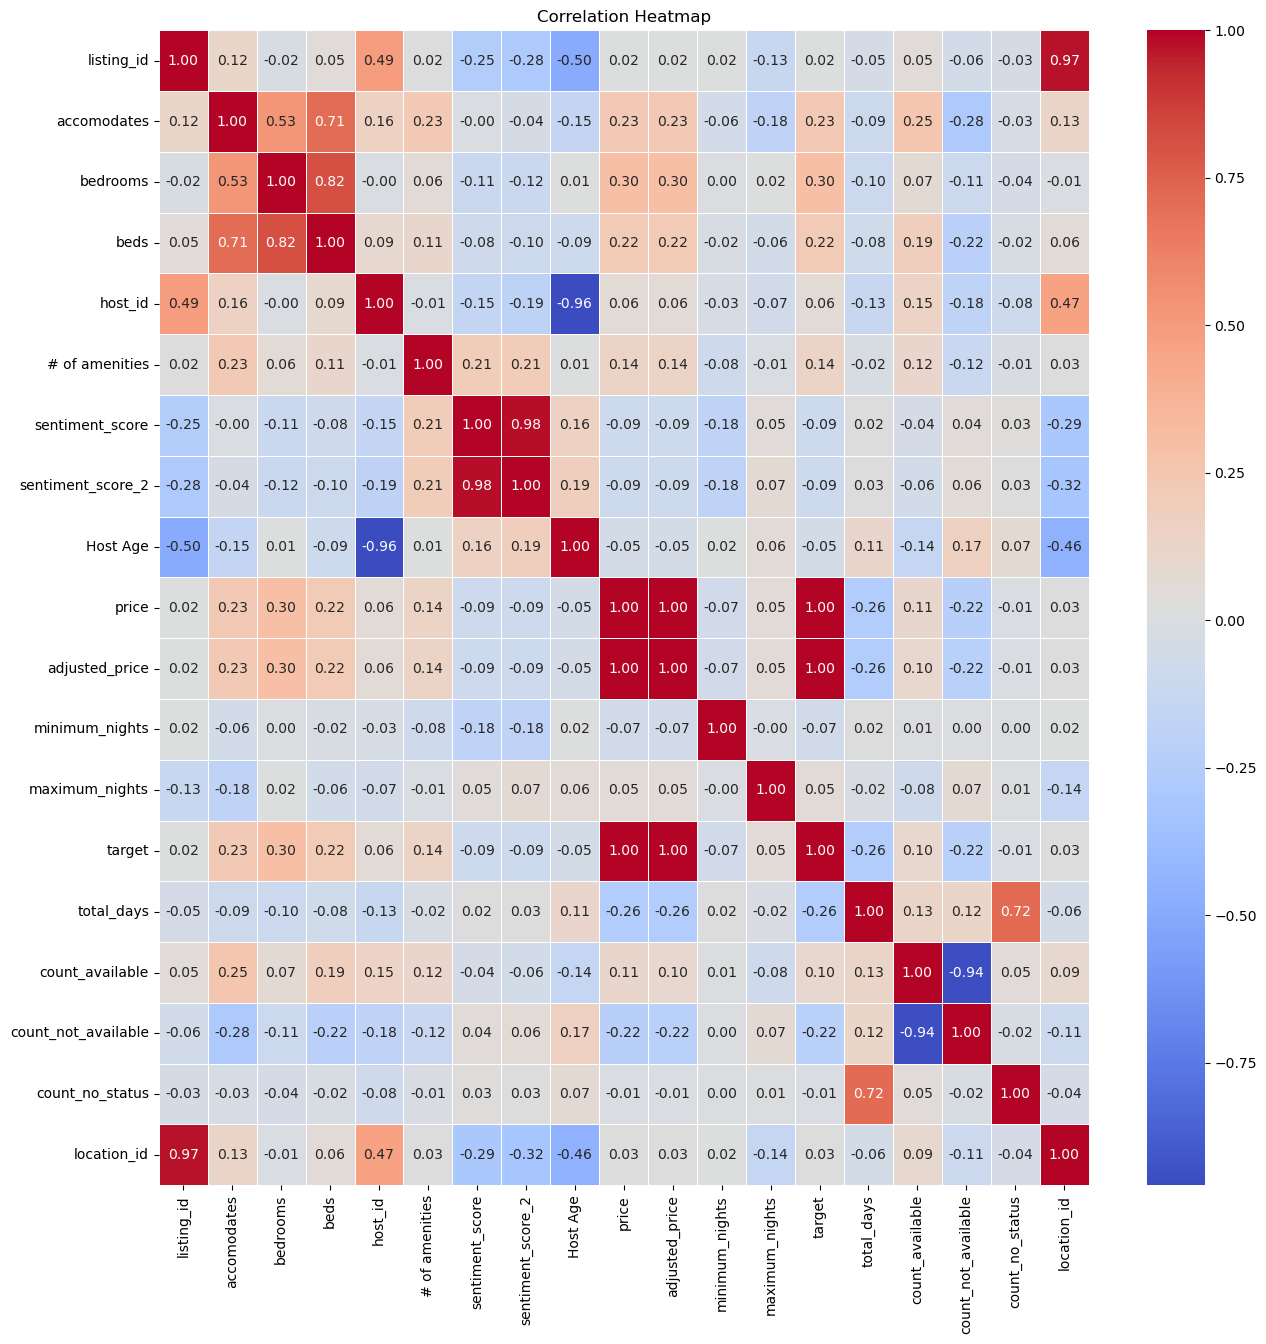

In [150]:
correlation_matrix = pridiction_df_num.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [155]:
X = pridiction_df_num[['accomodates', 'bedrooms', 'beds', '# of amenities', 'sentiment_score', 'sentiment_score_2', 
          'Host Age', 'minimum_nights', 'maximum_nights', 'total_days', 'count_available', 
          'count_not_available', 'count_no_status', 'location_id']]
y = pridiction_df_num['price']
X = X.fillna(X.mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
gbm_model = GradientBoostingRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
elastic_net_model = ElasticNet(random_state=42)
knn_model = KNeighborsRegressor()
lr_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gbm_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
elastic_net_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
dt_pred = dt_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
gbm_pred = gbm_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
elastic_net_pred = elastic_net_model.predict(X_test)
knn_pred = knn_model.predict(X_test)
models = {"Linear Regression": lr_pred, 
          "Decision Tree Regressor": dt_pred, 
          "Random Forest Regressor": rf_pred, 
          "Gradient Boosting Regressor": gbm_pred,
          "XGBoost Regressor": xgb_pred,
          "ElasticNet Regression": elastic_net_pred,
          "KNN Regressor": knn_pred}

for name, pred in models.items():
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"{name}:")
    print("  Mean Squared Error:", mse)
    print("  R² Score:", r2)


Linear Regression:
  Mean Squared Error: 1114.9229335658083
  R² Score: 0.2676209424656736
Decision Tree Regressor:
  Mean Squared Error: 1741.9064093860254
  R² Score: -0.14423673243406254
Random Forest Regressor:
  Mean Squared Error: 982.2064130873497
  R² Score: 0.35480077997819304
Gradient Boosting Regressor:
  Mean Squared Error: 995.1114363065627
  R² Score: 0.3463236301607451
XGBoost Regressor:
  Mean Squared Error: 1109.5089168530876
  R² Score: 0.27117734294696605
ElasticNet Regression:
  Mean Squared Error: 1158.9902902709605
  R² Score: 0.2386736419840808
KNN Regressor:
  Mean Squared Error: 1628.8197374739286
  R² Score: -0.06995149916705268


c:\Users\rsrdj\.conda\envs\minimal_ds\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.048e+05, tolerance: 2.003e+02
  


#### Linear Regression:

* Mean Squared Error (MSE): 1114.92
* R² Score: 0.268
* The MSE measures the average squared difference between the actual and predicted values. A lower MSE indicates better model performance. The R² score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. An R² score closer to 1 indicates a better fit. The Linear Regression model has a moderate MSE and R² score.
#### Decision Tree Regressor:

* MSE: 1741.91
* R² Score: -0.144
* The Decision Tree Regressor has a higher MSE and a negative R² score, indicating poor performance compared to the Linear Regression model. It might be overfitting the data.
#### Random Forest Regressor:

* MSE: 982.21
* R² Score: 0.355
* The Random Forest Regressor has a lower MSE and a higher R² score compared to the Linear Regression model, suggesting better performance. It's an ensemble learning method that uses multiple decision trees for prediction.
#### Gradient Boosting Regressor:

* MSE: 995.11
* R² Score: 0.346
* Similar to the Random Forest Regressor, the Gradient Boosting Regressor has a lower MSE and a higher R² score compared to Linear Regression, indicating better performance. It sequentially adds predictors to minimize the errors of previous predictors.
#### XGBoost Regressor:

* MSE: 1109.51
* R² Score: 0.271
* XGBoost is an advanced implementation of gradient boosting algorithms and provides similar performance to Gradient Boosting Regressor.
#### ElasticNet Regression:

* MSE: 1158.99
* R² Score: 0.239
* ElasticNet Regression combines the penalties of Lasso and Ridge regression and provides slightly worse performance compared to Linear Regression.
#### KNN Regressor:

* MSE: 1628.82
* R² Score: -0.070
* The KNN Regressor has the highest MSE and a negative R² score, indicating poor performance compared to other models. It might not be suitable for this dataset.

Size of train dataset: 1333
Size of test dataset: 334


c:\Users\rsrdj\.conda\envs\minimal_ds\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.048e+05, tolerance: 2.003e+02
  
c:\Users\rsrdj\.conda\envs\minimal_ds\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.048e+05, tolerance: 2.003e+02
  


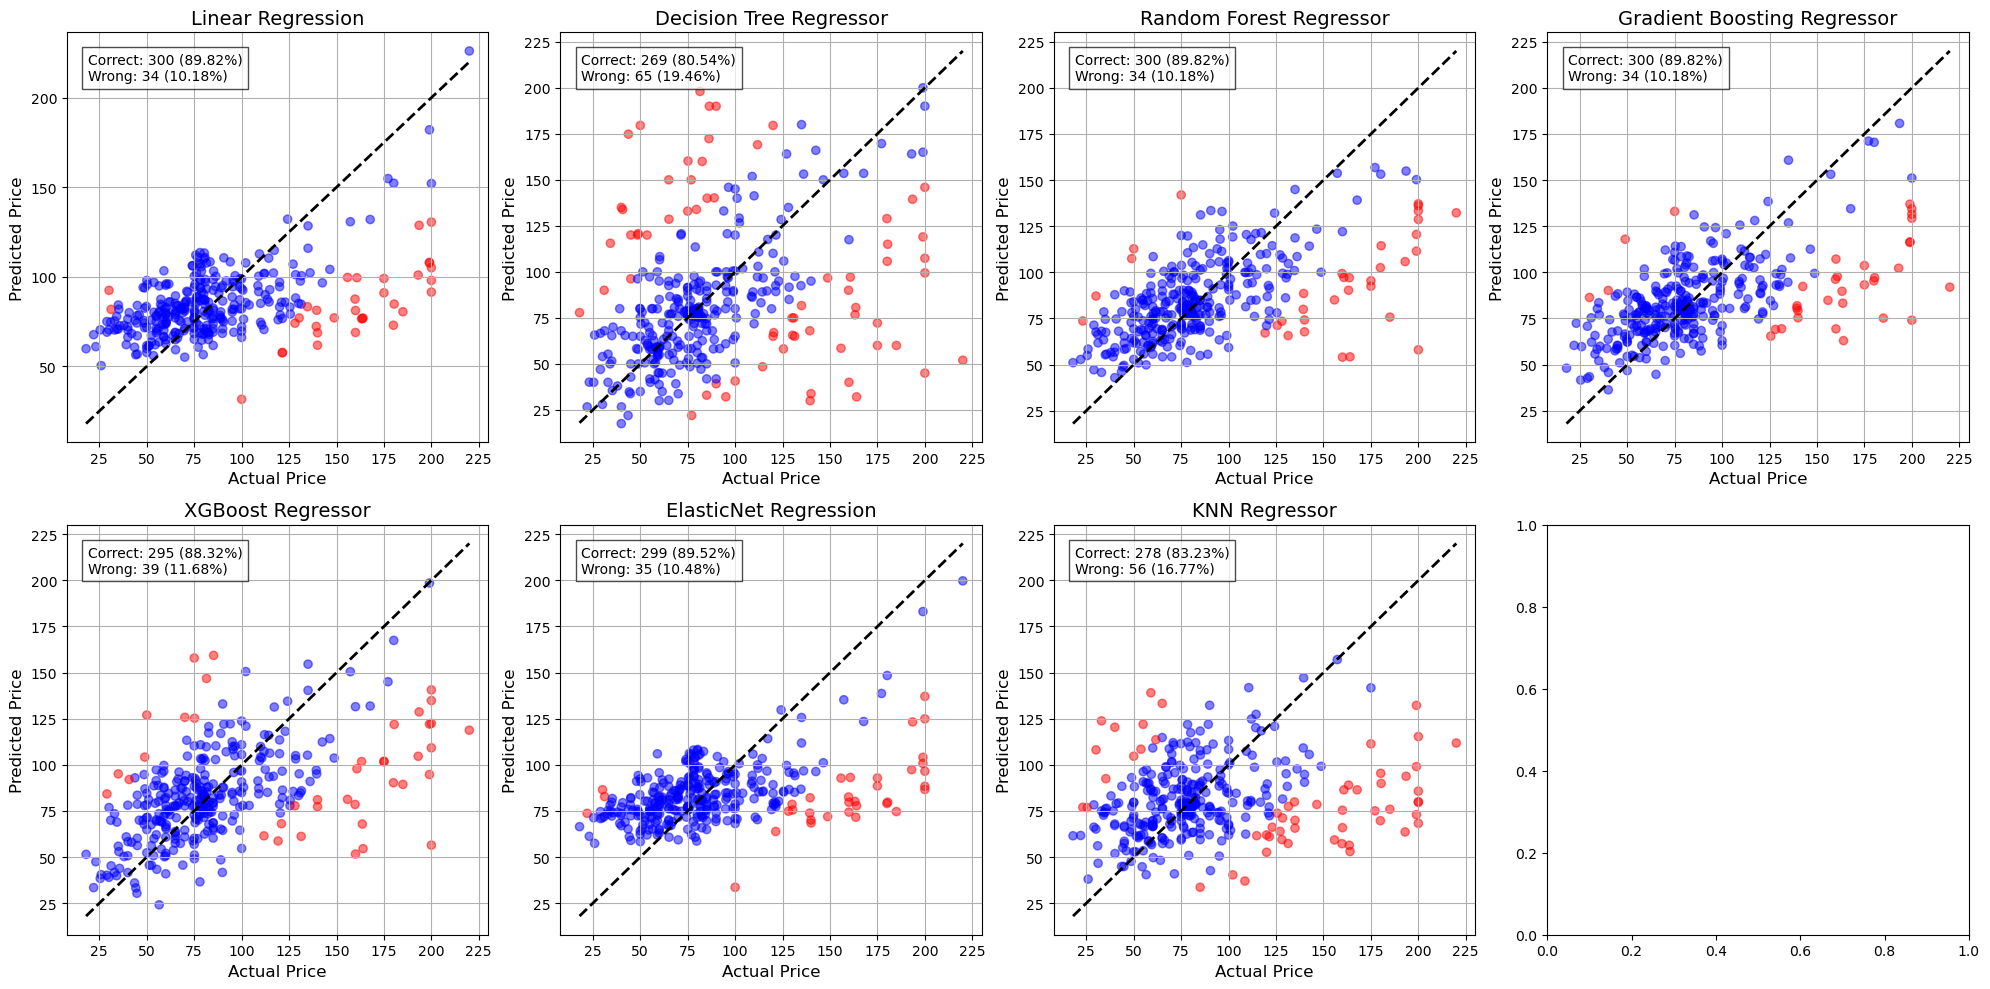

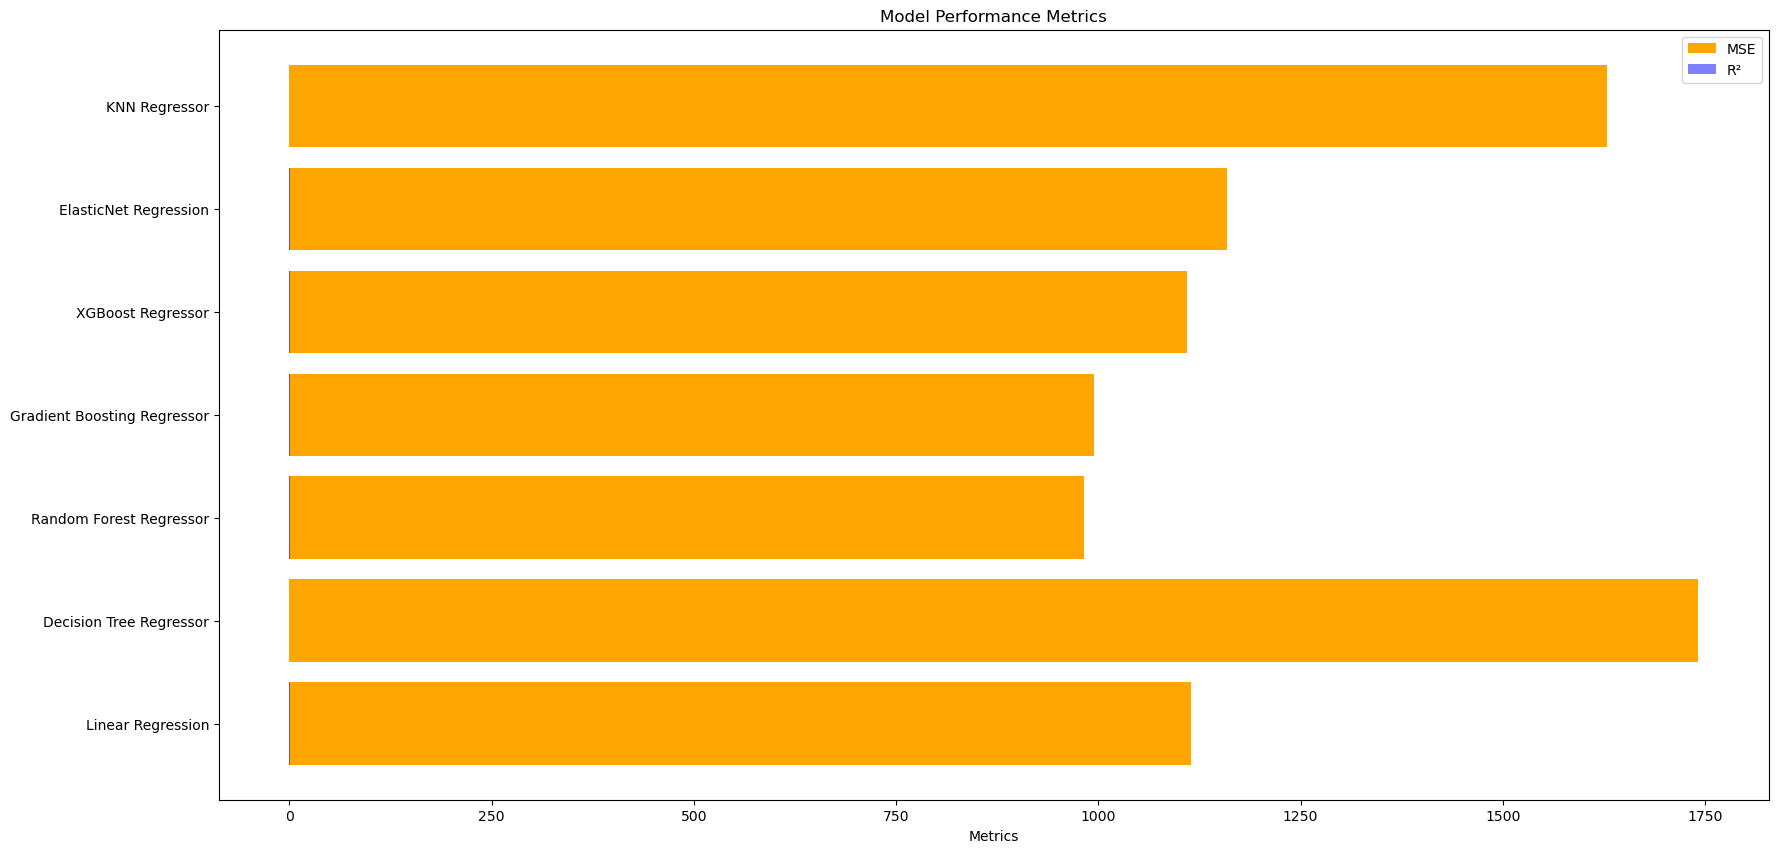

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Size of train dataset:", len(X_train))
print("Size of test dataset:", len(X_test))
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42),
    "ElasticNet Regression": ElasticNet(random_state=42),
    "KNN Regressor": KNeighborsRegressor()
}
prediction_counts = {}
threshold = 50

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals = np.abs(y_test - y_pred)  
    wrong_predictions = X_test[residuals > threshold]
    total_points = len(y_test)
    correct_predictions = total_points - len(wrong_predictions)
    correct_percentage = (correct_predictions / total_points) * 100
    wrong_percentage = (len(wrong_predictions) / total_points) * 100
    
    prediction_counts[name] = {
        "correct": correct_predictions, 
        "wrong": len(wrong_predictions),
        "correct_percentage": correct_percentage,
        "wrong_percentage": wrong_percentage
    }

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for ax, (name, model) in zip(axs.ravel(), models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals = np.abs(y_test - y_pred)
    ax.scatter(y_test, y_pred, c=np.where(residuals > threshold, 'red', 'blue'), alpha=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    ax.set_title(name, fontsize=14)
    ax.set_xlabel('Actual Price', fontsize=12)
    ax.set_ylabel('Predicted Price', fontsize=12)
    ax.grid(True)
    counts = prediction_counts[name]
    textstr = f"Correct: {counts['correct']} ({counts['correct_percentage']:.2f}%)\nWrong: {counts['wrong']} ({counts['wrong_percentage']:.2f}%)"
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()



plt.figure(figsize=(20, 10))
models_names = list(results.keys())
mse_values = [results[name]["MSE"] for name in models_names]
r2_values = [results[name]["R2"] for name in models_names]
plt.barh(models_names, mse_values, color='orange', label='MSE')
plt.barh(models_names, r2_values, color='blue', alpha=0.5, label='R²')
plt.xlabel('Metrics')
plt.title('Model Performance Metrics')
plt.legend()
plt.show()
